# Code for processing the data from the Moser group (Vollan et al., 2025) and fitting the GPLVM

In [120]:
import numpy as np
import jax.numpy as jnp
import jax.random as jr
import poor_man_gplvm as pmg
import matplotlib.pyplot as plt
from scipy.special import logsumexp
import seaborn as sns
import os

from core import *

%matplotlib widget

In [122]:

def preprocess_moser_data(
    mat_path: str,
    window_size: float = 1.0,
    step_size: float = 0.5,
    use_units: str = "all",
    sigma: float = 0,
    zscore: bool = False,
    locations: str = "both",
):
    """
    Preprocess Moser navigation data into sliding-window spike counts and tracking.

    Parameters
    ----------
    mat_path : str
        Path to the `{ratID}_{sessionID}.mat` file containing a `Dsession` struct.
    window_size : float, optional
        Sliding window size in seconds (as in `compute_spike_counts`), default 1.0.
    step_size : float, optional
        Step between successive windows in seconds, default 0.5.
    use_units : str, optional
        Filter for unit quality labels (based on `ks2Label` in Moser data):
        - 'all'       : include all units
        - 'good'      : include only ks2Label == 'good'
        - 'mua'       : include only ks2Label == 'mua'
        - 'good/mua'  : include ks2Label in {'good','mua'}
        - 'noise'     : include only ks2Label == 'noise'
        Default 'all'.
    sigma : float or None, optional
        Std dev (in window steps) for Gaussian smoothing of spike counts along time.
        If 0 or None, no smoothing. Default 0.
    zscore : bool, optional
        If True, z-score spike counts across time per unit. Default False.
    locations : {'both', 'mec', 'hc'}, optional
        Which anatomical locations to include from `Dsession.units`. Default 'both'.

    Returns
    -------
    spike_count_matrix : ndarray, shape (num_units, num_windows)
        Sliding-window spike counts (optionally smoothed and z-scored).
    time_bins : ndarray, shape (num_windows,)
        Window start times in *relative* seconds (0 at first tracking sample),
        matching the convention of `compute_spike_counts`.
    units : ndarray of str, shape (num_units,)
        Unit identifiers (e.g. "2_1039") corresponding to rows of `spike_count_matrix`.
    x_win : ndarray, shape (num_windows,)
        X-position (meters) at the center of each window (interpolated from tracking).
    y_win : ndarray, shape (num_windows,)
        Y-position (meters) at the center of each window.
    z_win : ndarray, shape (num_windows,)
        Z-position (meters) at the center of each window.

    Notes
    -----
    - Uses `Dsession.t` as the reference time grid; all times are shifted so that
      the first tracking time corresponds to 0 seconds.
    - Spike times are taken from `Dsession.units.<mec/hc>(i).spikeTimes` and clipped
      to the [t[0], t[-1]] range so that spikes outside the tracked period are ignored.
    - Position is *interpolated* at window centers (not averaged), which keeps this
      routine efficient even for long recordings.
    """

    # ---------------------------------------------------------------------
    # 1) Load MATLAB struct and sanity-check
    # ---------------------------------------------------------------------
    if not os.path.exists(mat_path):
        raise FileNotFoundError(f"MAT-file not found: {mat_path}")

    mat = loadmat(mat_path, squeeze_me=True, struct_as_record=False)
    Dsession = mat.get("Dsession", None)
    if Dsession is None:
        raise ValueError(
            f"{mat_path} does not contain a 'Dsession' struct. "
            "This function currently supports navigation sessions only."
        )

    # ---------------------------------------------------------------------
    # 2) Extract tracking data and build time axis
    # ---------------------------------------------------------------------
    t = np.asarray(Dsession.t, dtype=float).ravel()
    x = np.asarray(Dsession.x, dtype=float).ravel()
    y = np.asarray(Dsession.y, dtype=float).ravel()
    z = np.asarray(Dsession.z, dtype=float).ravel()

    if not (t.size == x.size == y.size == z.size):
        raise ValueError(
            "Dsession.t, x, y, z must have the same length; "
            f"got t={t.size}, x={x.size}, y={y.size}, z={z.size}."
        )

    # Shift so that first tracking time is 0, to mirror `compute_spike_counts` style
    t0 = float(t[0])
    t_rel = t - t0
    recording_duration = float(t_rel[-1])

    # If the recording is too short for a single window, we return empty windows
    if recording_duration < window_size:
        # No windows, but we still may want unit IDs; extract them below
        num_windows = 0
        time_bins = np.zeros((0,), dtype=float)
    else:
        # Number of windows and their start times (same convention as compute_spike_counts)
        num_windows = 1 + int(np.floor((recording_duration - window_size) / step_size))
        time_bins = np.arange(num_windows, dtype=float) * step_size  # window starts

    # ---------------------------------------------------------------------
    # 3) Helper to flatten MATLAB struct arrays of units
    # ---------------------------------------------------------------------
    def _flatten_units(field):
        """Turn a MATLAB struct field into a Python list of unit structs."""
        if field is None:
            return []
        if isinstance(field, np.ndarray):
            if field.size == 0:
                return []
            return list(field.ravel())
        else:
            # Single struct, not an array
            return [field]

    # ---------------------------------------------------------------------
    # 4) Collect unit info (id, ks2Label, spikeTimes) from MEC / HC
    # ---------------------------------------------------------------------
    all_units_info = []

    units_struct = getattr(Dsession, "units", None)
    if units_struct is None:
        raise ValueError("Dsession.units is missing; cannot extract spike data.")

    locations = locations.lower()
    include_mec = locations in ("both", "mec")
    include_hc = locations in ("both", "hc")

    if include_mec and hasattr(units_struct, "mec"):
        mec_units = _flatten_units(units_struct.mec)
        for u in mec_units:
            all_units_info.append(("mec", u))

    if include_hc and hasattr(units_struct, "hc"):
        hc_units = _flatten_units(units_struct.hc)
        for u in hc_units:
            all_units_info.append(("hc", u))

    if len(all_units_info) == 0:
        # No units in requested locations
        return (
            np.zeros((0, 0), dtype=float),
            time_bins,
            np.array([], dtype=str),
            np.zeros_like(time_bins),
            np.zeros_like(time_bins),
            np.zeros_like(time_bins),
        )

    # ---------------------------------------------------------------------
    # 5) Build per-unit dicts and apply use_units filter
    # ---------------------------------------------------------------------
    units_info = []
    for loc, u in all_units_info:
        # Unit identifier as string
        unit_id = str(getattr(u, "id", ""))

        # Quality label; default to 'mua' if missing
        ks2_label = getattr(u, "ks2Label", None)
        if ks2_label is None:
            label = "mua"
        else:
            label = str(ks2_label).lower()

        
        meanRate = getattr(u, "meanRate", None)


        # Spike times (seconds), clipped to the tracked period [t0, t[-1]]
        spike_times = np.asarray(getattr(u, "spikeTimes", []), dtype=float).ravel()
        if spike_times.size > 0:
            # Keep only spikes within tracking range
            mask = (spike_times >= t0) & (spike_times <= t[-1])
            spike_times = spike_times[mask] - t0  # shift to same 0 as t_rel

        units_info.append(
            {
                "id": unit_id,
                "label": label,
                "location": loc,
                "spike_times": spike_times,
                "mean_rate": meanRate,
            }
        )

    # Apply use_units filter, analogous to compute_spike_counts
    use_units = use_units.lower()
    if use_units == "all":
        kept_units = units_info
    elif use_units == "good":
        kept_units = [u for u in units_info if u["label"] == "good"]
    elif use_units == "mua":
        kept_units = [u for u in units_info if u["label"] == "mua"]
    elif use_units in ("good/mua", "good+mua", "goodmua"):
        kept_units = [u for u in units_info if u["label"] in ("good", "mua")]
    elif use_units == "noise":
        kept_units = [u for u in units_info if u["label"] == "noise"]
    else:
        raise ValueError(f"Unknown use_units='{use_units}'")

    if len(kept_units) == 0:
        # No units after filtering: we still return tracking
        x_win = np.zeros_like(time_bins)
        y_win = np.zeros_like(time_bins)
        z_win = np.zeros_like(time_bins)
        if num_windows > 0:
            # Interpolate tracking at window centers
            centers = time_bins + window_size / 2.0
            x_win = np.interp(centers, t_rel, x)
            y_win = np.interp(centers, t_rel, y)
            z_win = np.interp(centers, t_rel, z)

        return (
            np.zeros((0, num_windows), dtype=float),
            np.array([], dtype=float),
            time_bins,
            np.array([], dtype=str),
            x_win,
            y_win,
            z_win,
        )

    # ---------------------------------------------------------------------
    # 6) Compute spike-count matrix: one row per unit, one column per window
    # ---------------------------------------------------------------------
    num_units = len(kept_units)
    spike_count_matrix = np.zeros((num_units, num_windows), dtype=float)

    if num_windows > 0:
        for i, u in enumerate(kept_units):
            st = u["spike_times"]
            if st.size == 0:
                continue

            # Assign spikes to window start indices (same logic as compute_spike_counts)
            start_idx = np.floor(st / step_size).astype(np.int64)
            valid = (start_idx >= 0) & (start_idx < num_windows)
            if not np.any(valid):
                continue
            start_idx = start_idx[valid]
            st_valid = st[valid]

            # Guard: spike must fall before window end
            win_end = start_idx * step_size + window_size
            valid2 = st_valid < win_end
            if not np.any(valid2):
                continue
            start_idx = start_idx[valid2]

            # Bin counts with np.bincount for this unit
            counts = np.bincount(start_idx, minlength=num_windows).astype(float)
            spike_count_matrix[i, :] = counts

        # Optional smoothing
        if sigma is not None and sigma > 0:
            for r in range(spike_count_matrix.shape[0]):
                spike_count_matrix[r, :] = gaussian_filter1d(
                    spike_count_matrix[r, :], sigma=sigma, mode="nearest"
                )

        # Optional z-scoring per unit across time
        if zscore and num_windows > 0:
            mean = spike_count_matrix.mean(axis=1, keepdims=True)
            std = spike_count_matrix.std(axis=1, keepdims=True)
            std[std == 0] = 1.0
            spike_count_matrix = (spike_count_matrix - mean) / std

    # ---------------------------------------------------------------------
    # 7) Interpolate x, y, z at window centers
    # ---------------------------------------------------------------------
    if num_windows > 0:
        centers = time_bins + window_size / 2.0
        x_win = np.interp(centers, t_rel, x)
        y_win = np.interp(centers, t_rel, y)
        z_win = np.interp(centers, t_rel, z)
    else:
        x_win = np.zeros((0,), dtype=float)
        y_win = np.zeros((0,), dtype=float)
        z_win = np.zeros((0,), dtype=float)

    # Unit ID array (strings) aligned with rows
    units = np.array([u["id"] for u in kept_units], dtype=str)

    # Mean rates array
    mean_rates = np.array([u["mean_rate"] for u in kept_units], dtype=float)

    return spike_count_matrix, mean_rates, time_bins, units, x_win, y_win, z_win


In [125]:
data_file = r'D:\sid\moser_vollan_2025\navigation\lt\29502_3.mat'

# Spike rate computation parameters
WINDOW_SIZE = 0.01         # s
STEP_SIZE   = 0.01        # s
USE_UNITS   = "good"       # {'all', 'good', 'mua'}


# Filtering thresholds
MIN_TOTAL_SPIKES   = 500
MIN_MEAN_RATE_HZ   = .05
MIN_PRESENCE_RATIO = 0.5
N_TIME_BINS        = 100    # coarse bins for presence ratio
MAX_RATE_HZ      = 2

In [126]:
spike_count_matrix, mean_rates, time_bins, units, x_win, y_win, z_win = preprocess_moser_data(data_file, window_size=WINDOW_SIZE, step_size=STEP_SIZE, use_units=USE_UNITS, locations="mec")

print(f'spike count matrix shape: {spike_count_matrix.shape}')
print(f'mean rates shape: {mean_rates.shape}')
print(f'time bins shape: {time_bins.shape}')
print(f'units shape: {units.shape}')
print(f'x_win shape: {x_win.shape}')
print(f'y_win shape: {y_win.shape}')
print(f'z_win shape: {z_win.shape}')


# remove units with mean rate > MAX_RATE_HZ
valid_units = mean_rates <= MAX_RATE_HZ
spike_count_matrix = spike_count_matrix[valid_units, :]
mean_rates = mean_rates[valid_units]
units = units[valid_units]

spike count matrix shape: (362, 255612)
mean rates shape: (362,)
time bins shape: (255612,)
units shape: (362,)
x_win shape: (255612,)
y_win shape: (255612,)
z_win shape: (255612,)


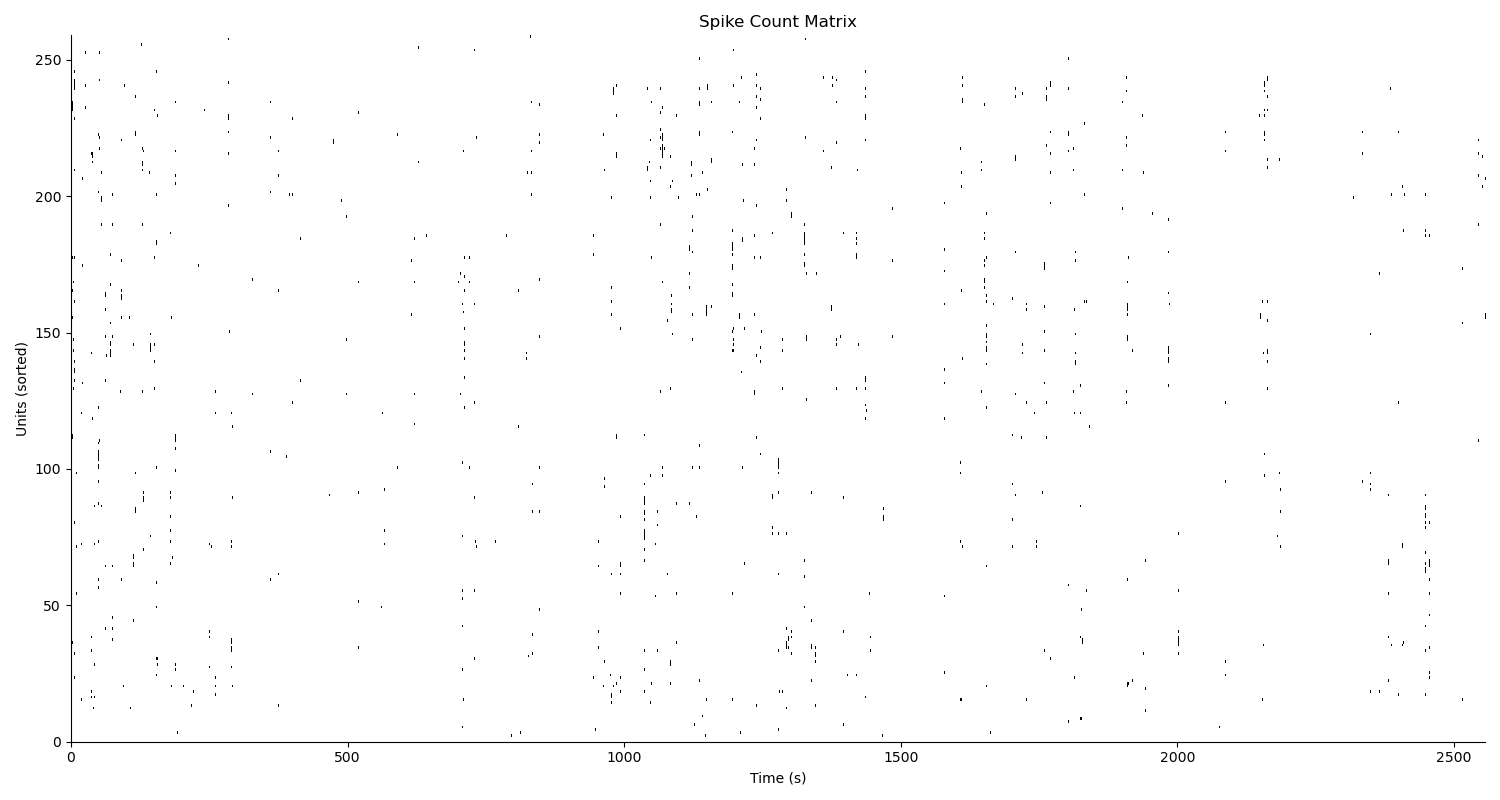

In [127]:
# sorting and plotting the spike count matrix
spike_count_matrix = sort_units(spike_count_matrix, mode='corr')

plt.figure(figsize=(15, 8))
plt.imshow(spike_count_matrix, aspect='auto', cmap='Greys', extent=[time_bins[0], time_bins[-1], 0, spike_count_matrix.shape[0]], vmin=0, vmax=1)
plt.xlabel('Time (s)')
plt.ylabel('Units (sorted)')
plt.title('Spike Count Matrix')
sns.despine()
plt.tight_layout()
plt.show()

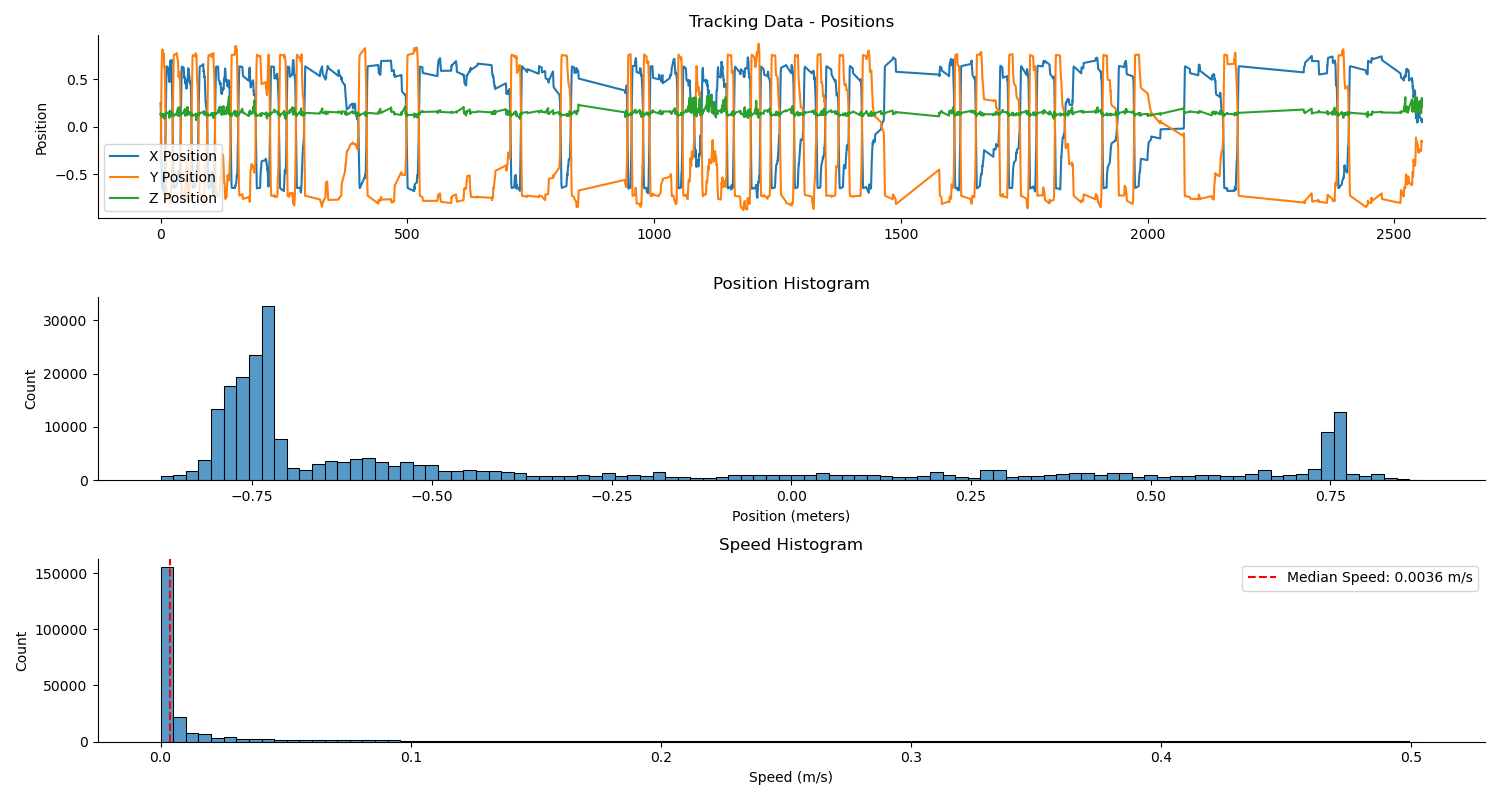

In [128]:
pos_raw = y_win
speed = np.abs(np.gradient(pos_raw) / np.gradient(time_bins))  # speed in m/s


# Plotting the tracking data
fig, axs = plt.subplots(3, 1, figsize=(15,8))

sns.lineplot(ax=axs[0], x=time_bins, y=x_win, label='X Position')
sns.lineplot(ax=axs[0], x=time_bins, y=y_win, label='Y Position')
sns.lineplot(ax=axs[0], x=time_bins, y=z_win, label='Z Position')
axs[0].set_ylabel('Position')
axs[0].set_title('Tracking Data - Positions')


sns.histplot(ax=axs[1], x=pos_raw, bins=100)
axs[1].set_xlabel('Position (meters)')
axs[1].set_ylabel('Count')
axs[1].set_title(f'Position Histogram')

sns.histplot(ax=axs[2], x=speed[speed < np.percentile(speed, 99)], bins=100)
axs[2].set_xlabel('Speed (m/s)')
axs[2].set_ylabel('Count')
axs[2].set_title('Speed Histogram')
axs[2].axvline(x = np.median(speed), color='red', linestyle='--', label=f'Median Speed: {np.median(speed):.4f} m/s')
axs[2].legend()
sns.despine()
plt.tight_layout()
plt.show()

In [129]:
# ------------------------CONFIG-------------------------
N_SPATIAL_BINS = 25
POS_MIN = -0.8
POS_MAX = 0.8


# Binning the position data
pos_bins = np.linspace(POS_MIN, POS_MAX, N_SPATIAL_BINS)
pos_bin_centers = (pos_bins[:-1] + pos_bins[1:]) / 2
pos_idx = np.digitize(pos_raw, pos_bins) - 1
pos_idx = np.clip(pos_idx, 0, N_SPATIAL_BINS - 1)


In [130]:
# Computing average firing rate across all units
fr = np.sum(spike_count_matrix, axis=0) / len(units) / WINDOW_SIZE  # in Hz

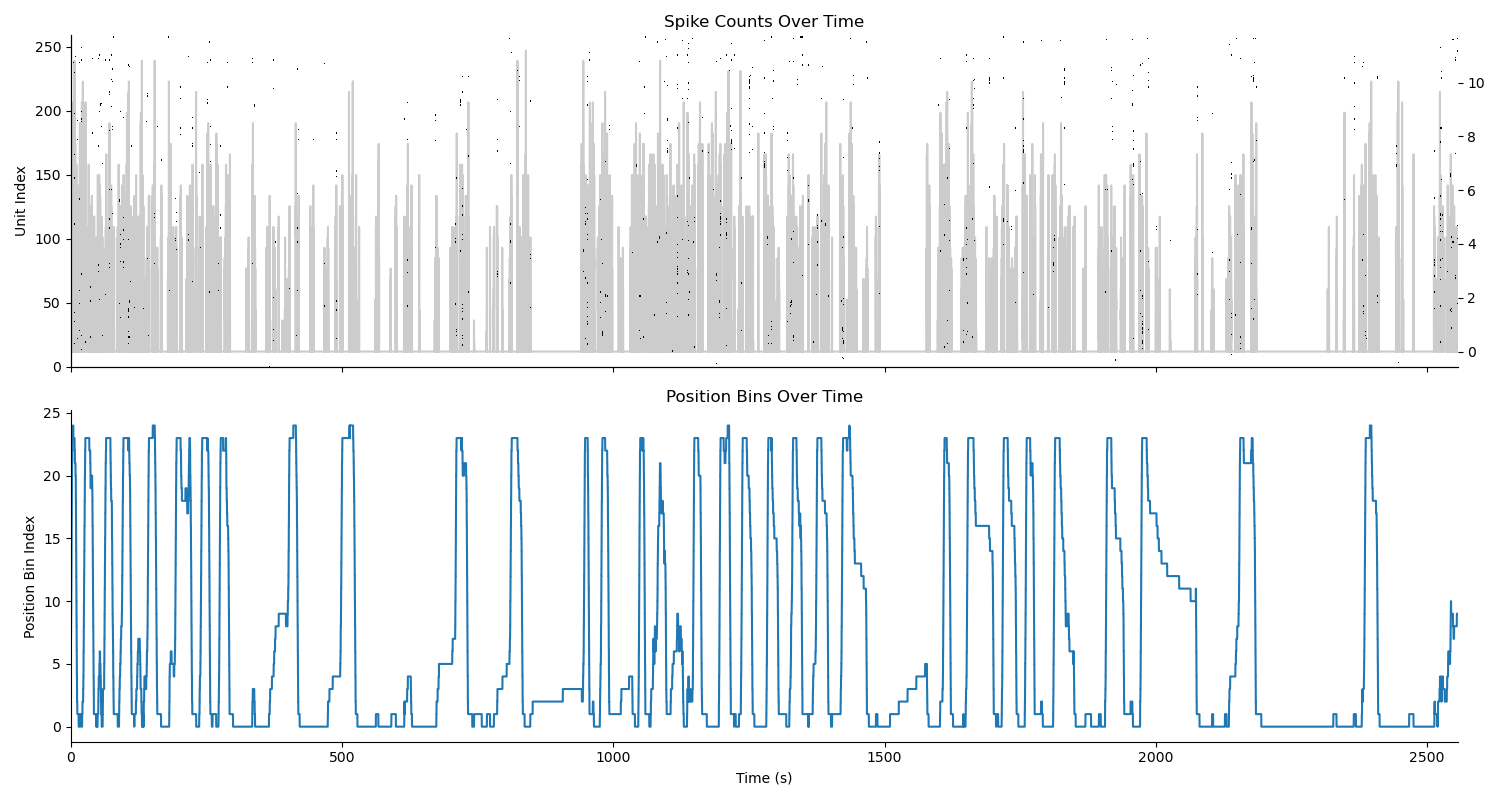

In [131]:
fig, axs = plt.subplots(2, 1, figsize=(15,8), sharex = True)
dt = np.mean(np.diff(time_bins))  # step_size
axs[0].imshow(spike_count_matrix, cmap='Greys', aspect='auto',extent=[time_bins[0], time_bins[-1] + dt, 0, spike_count_matrix.shape[0]], origin='lower', vmin=0, vmax=1)
axs[0].twinx().plot(time_bins, fr, color='k', label='Firing Rate (Hz)', alpha = 0.2)
axs[1].plot(time_bins, pos_idx)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Position Bin Index')
axs[1].set_title('Position Bins Over Time')
axs[0].set_ylabel('Unit Index')
axs[0].set_title('Spike Counts Over Time')
plt.tight_layout()
sns.despine()
plt.show()

In [132]:
# Define poisson Bayesian decoder model
model = PoissonBayesDecoder(n_bins=N_SPATIAL_BINS, rate_floor=1e-4, uniform_prior=True)

# fitting the model
model.fit(spike_count_matrix, pos_idx)

# poisson bayessian decoding
log_probs = model.predict_log_probabilities(spike_count_matrix)
posterior = np.exp(log_probs - logsumexp(log_probs, axis=0, keepdims=True))





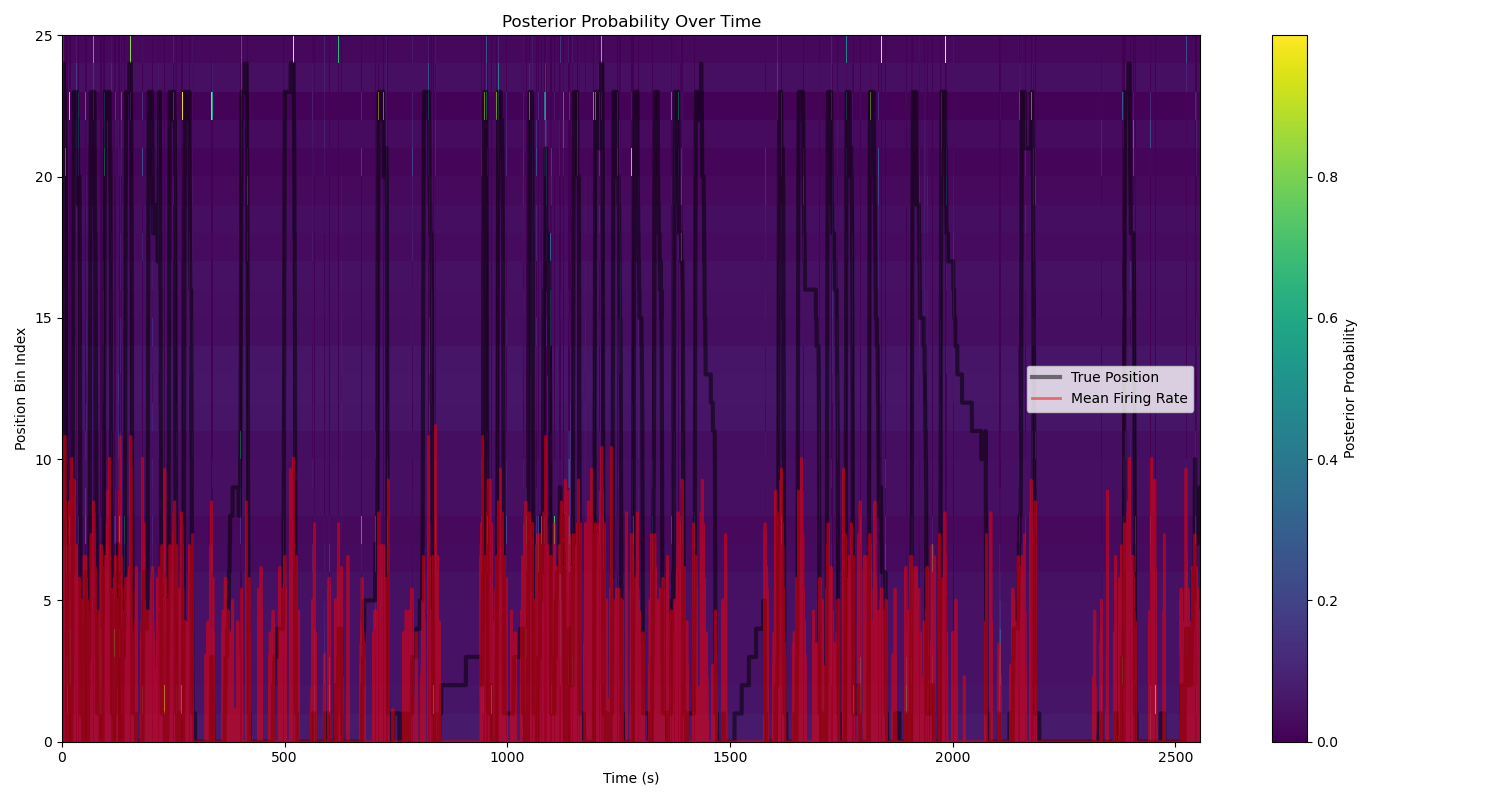

In [133]:
plt.figure(figsize=(15,8))
plt.imshow(posterior, cmap='viridis', aspect='auto', extent=[time_bins[0], time_bins[-1] + dt, 0, N_SPATIAL_BINS], origin='lower')
plt.plot(time_bins, pos_idx, color='k', label='True Position', alpha=0.5, linewidth=3)
plt.plot(time_bins, fr, color='r', label='Mean Firing Rate', alpha=0.5, linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Position Bin Index')
plt.title('Posterior Probability Over Time')
cbar = plt.colorbar()
cbar.set_label('Posterior Probability')
plt.tight_layout()
plt.legend()
plt.show()


In [134]:
# -----------------------GPLVM CONFIG-------------------------
N_LATENT_BINS = 25
movement_variance = 1.0
tuning_lengthscale = 10.0

n_neuron = spike_count_matrix.shape[0]
latent_model =pmg.PoissonGPLVMJump1D(n_neuron, n_latent_bin=N_LATENT_BINS, movement_variance=movement_variance, tuning_lengthscale=tuning_lengthscale)
em_res = latent_model.fit_em(spike_count_matrix.T, key=jr.PRNGKey(3), n_iter=10, log_posterior_init=None, ma_neuron=None, ma_latent=None, n_time_per_chunk=10000)


EM: 100%|██████████| 10/10 [03:14<00:00, 19.44s/it]


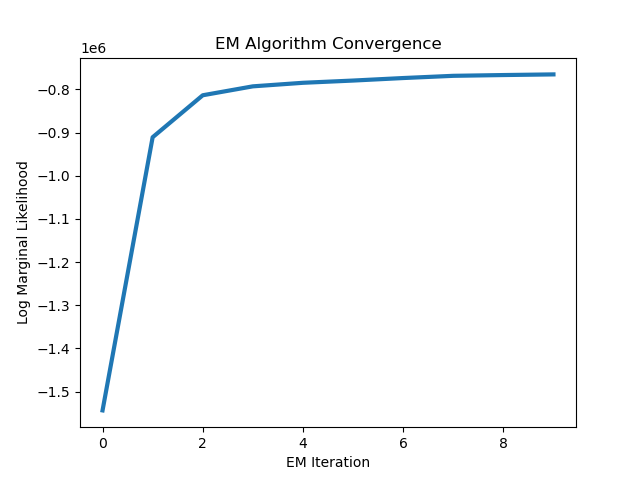

In [137]:
plt.figure()
plt.plot(em_res['log_marginal_l'], linewidth=3)
plt.xlabel('EM Iteration')
plt.ylabel('Log Marginal Likelihood')
plt.title('EM Algorithm Convergence')
plt.show()

C:\Users\SB13FLPC020\AppData\Local\Temp\ipykernel_47388\3514291204.py:9: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



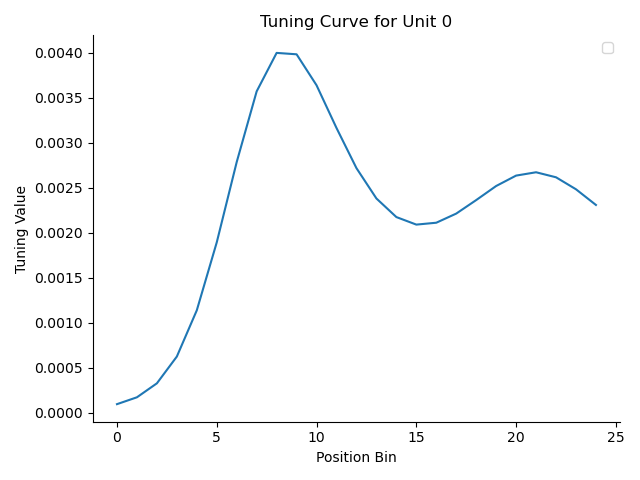

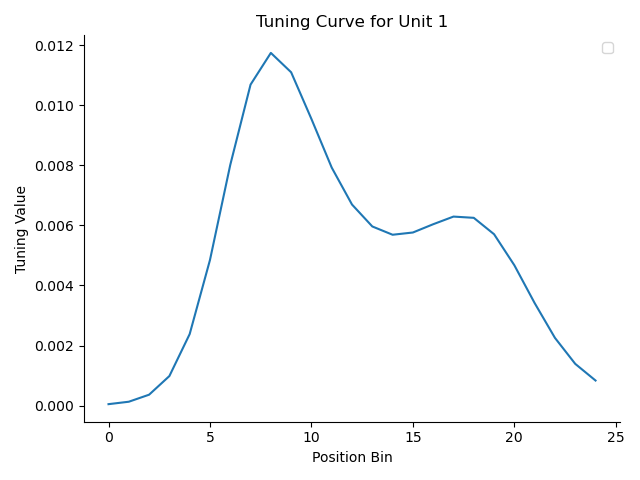

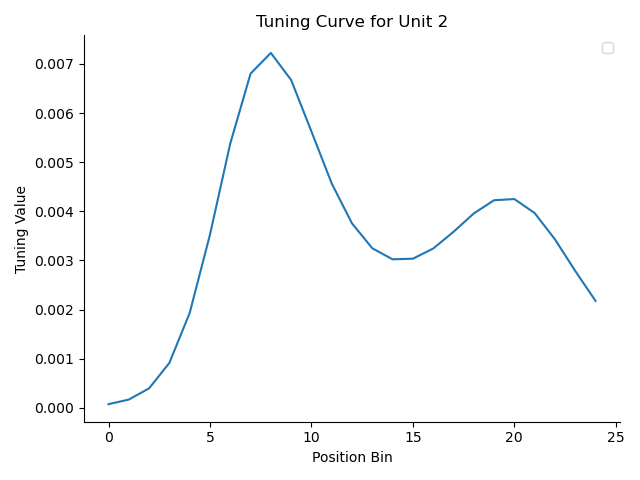

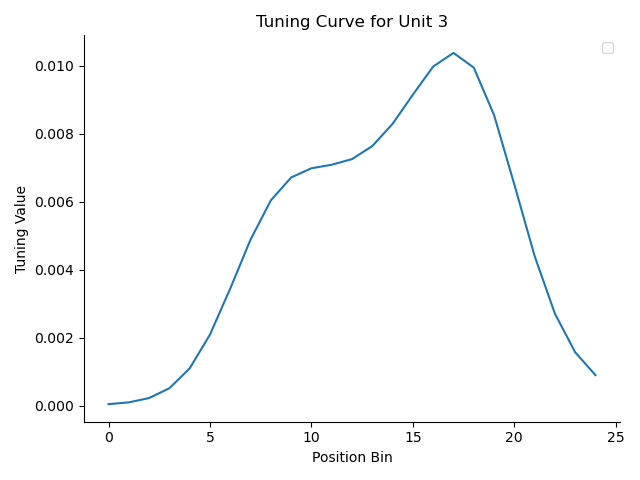

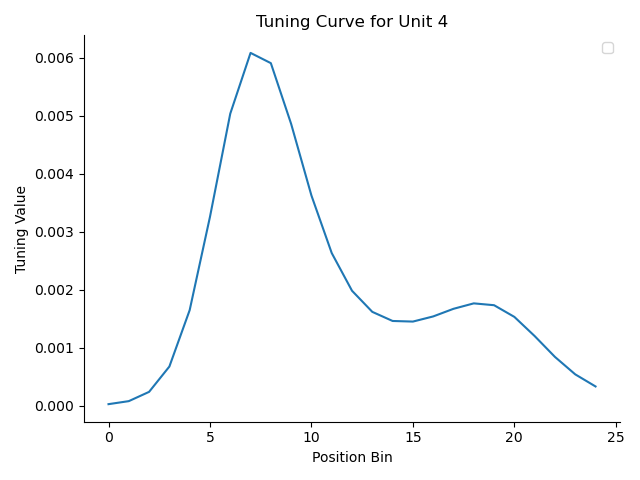

In [138]:
tuning_curves= latent_model.tuning
for neuron in range(5):
    plt.figure()
    plt.plot(tuning_curves[:, neuron])

    plt.title(f'Tuning Curve for Unit {neuron}')
    plt.xlabel('Position Bin')
    plt.ylabel('Tuning Value')
    plt.legend()
    sns.despine()
    plt.tight_layout()
    plt.show()

In [139]:
decode_res = latent_model.decode_latent(spike_count_matrix.T)

latent_posterior = decode_res['posterior_latent_marg']

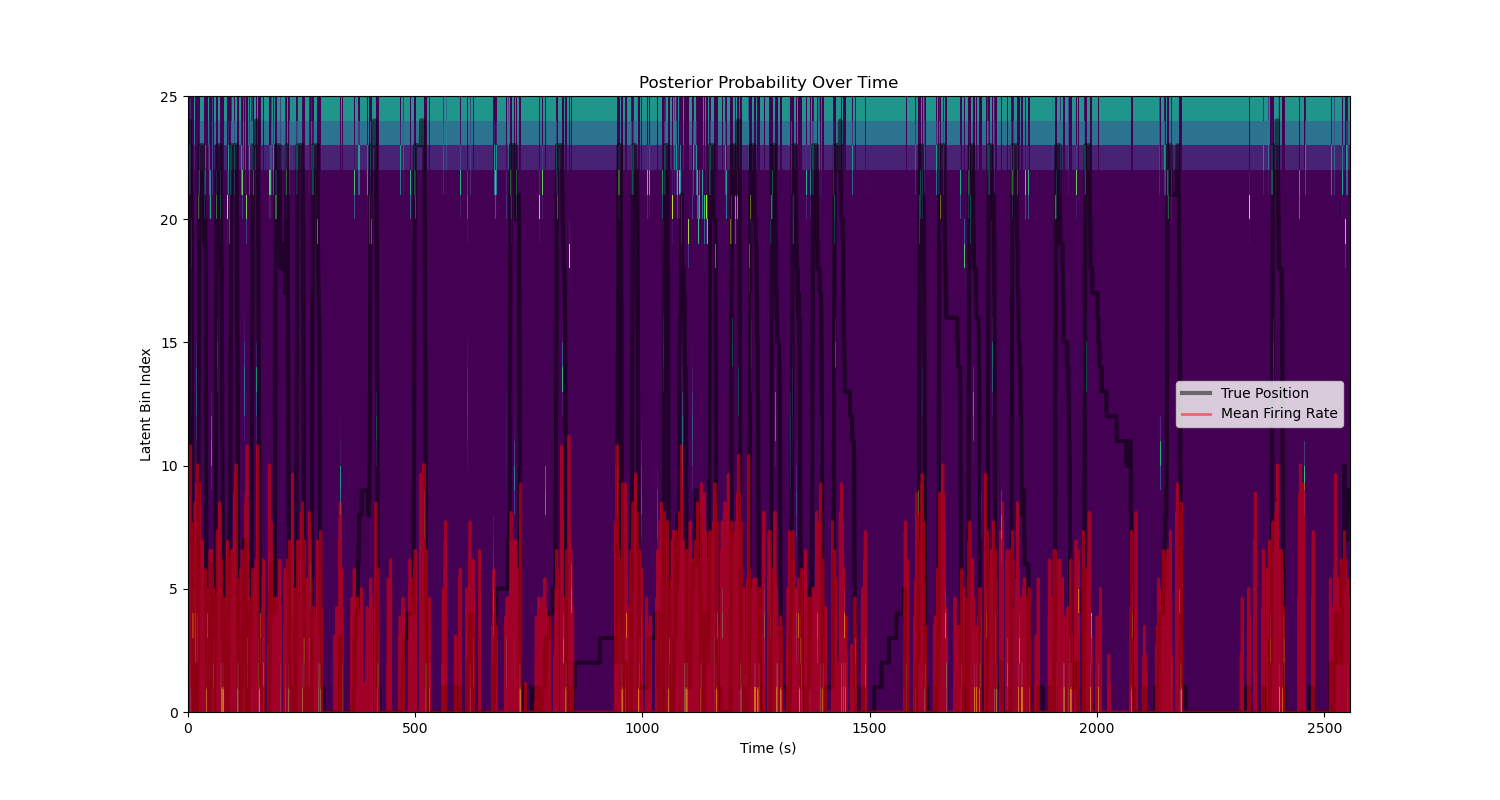

In [ ]:
plt.figure(figsize=(15,8))
plt.imshow(latent_posterior.T, cmap='viridis', aspect='auto', extent=[time_bins[0], time_bins[-1] + dt, 0, N_LATENT_BINS], origin='upper')
#overlay true position
plt.plot(time_bins, pos_idx, color='k', label='True Position', alpha=0.5, linewidth=3)
plt.plot(time_bins, fr, color='r', label='Mean Firing Rate', alpha=0.5, linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Latent Bin Index')
plt.title('Posterior Probability Over Time')
plt.legend()
plt.show()
